# Micrograd-From-Scratch

In [30]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
def f(x):
    return 3*x**2 -4*x + 5

In [32]:
f(3.0)

20.0

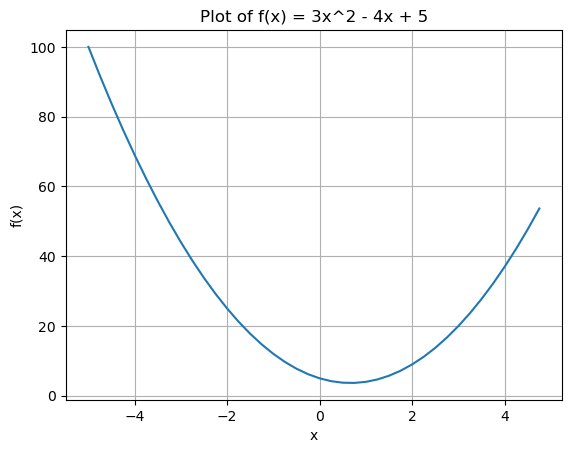

In [33]:
xs = np.arange(-5,5, 0.25)# Generate a range of x values
ys = f(xs) # Compute the corresponding y values
plt.plot(xs, ys)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Plot of f(x) = 3x^2 - 4x + 5')
plt.grid()
plt.show()

In [35]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [36]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [37]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


### Building Core Value Object of MicroGrad and its Visualisation

In [44]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data# value of this node
        self.grad = 0.0# gradient of this node
        self._backward = lambda: None# function to compute the gradient. here lambda  is used to create a function that does nothing
        self._prev = set(_children)# previous nodes in the computation graph
        self._op = _op#  operation to produce this node
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') # creating a new Value object with the sum of self and other
        
        def _backward():
            self.grad += 1.0 * out.grad # gradient of self is incremented by the gradient of out
            other.grad += 1.0 * out.grad # gradient of other is incremented by the gradient of out
        out._backward = _backward # assigning the backward function to the out object
        return out # returning the new Value object
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*') # creating a new Value object with the product of self and other
        
        def _backward():
            self.grad += other.data * out.grad # gradient of self is incremented by the product of other data and out gradient
            other.grad += self.data * out.grad # gradient of other is incremented by the product of self data and out gradient
        out._backward = _backward # assigning the backward function to the out object
        return out
    
    def tanh(self):
        x = self.data# hyperbolic tangent function
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) # calculating tanh using the exponential function
        out = Value(t, (self, ), 'tanh')# creating a new Value object with the tanh value

        def _backward():
            self.grad += (1 - t**2) * out.grad# gradient of self is incremented by the derivative of tanh multiplied by the gradient of out
        out._backward = _backward# assigning the backward function to the out object

        return out
    
    def backward(self):
        topo = []# topological order of the computation graph
        visited = set()# set to keep track of visited nodes
        def build_topo(v):
            if v not in visited:
                visited.add(v)# adding the node to the visited set
                for child in v._prev:# iterating through the previous nodes
                    build_topo(child)# recursively building the topological order
                topo.append(v)# appending the node to the topological order
        build_topo(self)# building the topological order starting from self
        
        self.grad = 1.0# setting the gradient of self to 1.0
        for node in reversed(topo):# iterating through the topological order in reverse
            node._backward()# calling the backward function of each node to compute the gradients




In [45]:
# creating a Value object with data 2.0 and label 'a'
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L

Value(data=-8.0)

In [46]:
from graphviz import Digraph


def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges


def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={
                'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (
        n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name=uid + n._op, label=n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

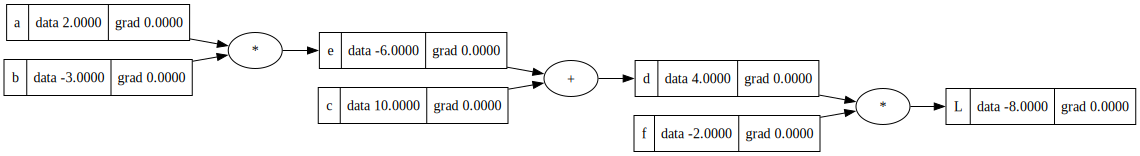

In [47]:
draw_dot(L)

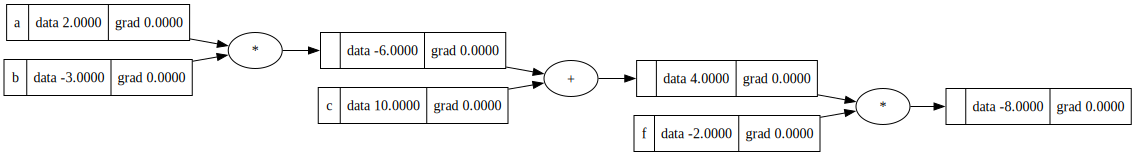

In [48]:
a.data += 0.01 * a.grad# updating the data of a by adding the product of its gradient and a small step size
b.data += 0.01 * b.grad# updating the data of b by adding the product of its gradient and a small step size
c.data += 0.01 * c.grad# updating the data of c by adding the product of its gradient and a small step size
f.data += 0.01 * f.grad# updating the data of f by adding the product of its gradient and a small step size

e = a * b# re-evaluating e after updating a and b
d = e + c
L = d * f# re-evaluating L after updating d and f

draw_dot(L)

In [49]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-8.0


In [50]:
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)


lol()

-3.9999999999995595


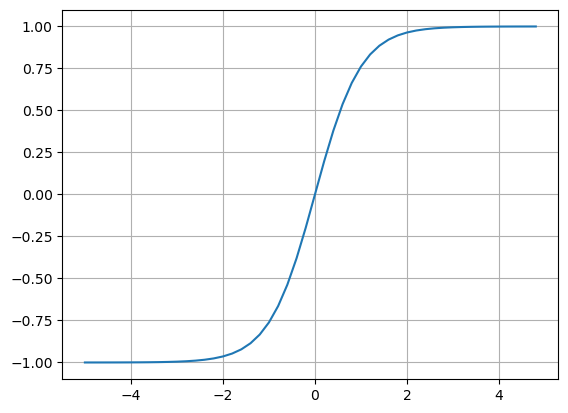

In [55]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()